In [1]:
from myImports import *

#For resetting matplotlib parameters --> latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [100]:
#Pass in point cloud data as np array
#implement a way to visualise distance via matching (choice of one arbitrary)
class PersisMod():
    def __init__(self, data, rval=None):
        self.data = data
        self.pd = self.calcpersis(self.data)
        self.mapping = rval
    def calcpersis(self,data):
        diag = ripser.ripser(data)["dgms"]
        df = pd.DataFrame()
        for i in range(len(diag)):
            temp = pd.DataFrame(diag[i],columns=["Birth","Death"])
            temp["HomologyG"] = i
            df = pd.concat([df,temp])
        return df

    def showGs(self):
        fig, ax = plt.subplots(1, 2,figsize=(7.5, 4))
        fig.tight_layout(pad=5)
        #Scatter
        ax[0].set_title("Point Cloud")
        ax[0].set_xlabel("x")
        ax[0].set_ylabel("y")
        ax[0].scatter(self.data[:,0],self.data[:,1],s=10)
        #PD
        df = self.pd.copy(deep=True)
        infrep = list(df["Death"].nlargest(2))[1]*1.02
        df.replace(float("inf"), infrep, inplace=True)
        diagonal = np.linspace(0, infrep, 250)
        infline = np.linspace(0, infrep, 250)
        ax[1].plot(diagonal,diagonal, linestyle="dashed",color="black", zorder=1)
        ax[1].plot(infline,[infrep for i in infline], linestyle="dashed",color="black",zorder=1)
        ax[1].set_title("Persistence Diagram")
        ax[1].set_xlabel("Birth")
        ax[1].set_ylabel("Death")
        hom1 = ax[1].scatter(df[df["HomologyG"]==0].Birth,df[df["HomologyG"]==0].Death,color="#83aff0",s=10)
        hom1.set_label("H0")
        hom2 = ax[1].scatter(df[df["HomologyG"]==1].Birth,df[df["HomologyG"]==1].Death,color="#2c456b",s=10)
        hom2.set_label("H1")
        
        ax[1].legend([hom1,hom2],["H0", "H1"],loc='lower right')
        plt.show()

In [94]:
def distance_between(pd1, pd2, metric):
    X = pd1.pd[["Birth", "Death"]].to_numpy()
    Y = pd2.pd[["Birth", "Death"]].to_numpy()
    if metric == "bottleneck": 
        res = gudhi.bottleneck_distance(X,Y)
    elif metric == "wasserstein22":
        res = wasserstein_distance(X, Y, order=2, internal_p=2)
    elif metric == "wasserstein11":
        res = wasserstein_distance(X, Y, order=1, internal_p=1)
    return res

#Is there a h in the denominator of Gaussian Kernel??
def ker(z):
    val = (1/(np.sqrt(2*np.pi)))*np.e**(-0.5*(z**2))
    return val

#ker should just return a single estimate
def nw_estimator(sample_distances,sample_values, h):
    total_ker = 0
    estimate = 0
    for i in range(len(sample_distances)):
        curr_ker = ker(sample_distances[i]/h)
        total_ker += curr_ker
        estimate += curr_ker * sample_values[i]
    final = estimate/total_ker
    return final

def knn_estimator(sample_distances,sample_values, h): 
    estimate = 0.0
    closest_samples = [x for _, x in sorted(zip(sample_distances, sample_values))]
    for i in range(h):
        estimate += closest_samples[i]
    return estimate/h

#Calculating CV parameter h
def find_CVh(training_dist_mat, hspace, training_set_Y, estimator):
    current_best_h = 0
    current_best_mse = np.inf
    for h in hspace:
        total_se = 0
        for i in range(len(training_dist_mat)):
            mod_training_dist = np.delete(training_dist_mat[i], i, 0)
            mod_training_Y = np.delete(training_set_Y, i, 0)
            if estimator == "nw":
                estimate = nw_estimator(mod_training_dist,mod_training_Y, h)
            elif estimator == "knn":
                estimate = knn_estimator(mod_training_dist,mod_training_Y, h)
            total_se += (estimate - training_set_Y[i])**2
        mse = total_se/len(training_dist_mat)
        if mse < current_best_mse:
            current_best_h = h
            current_best_mse = mse
    return current_best_h

#Distance Correlations
def dist_cov(distMat1, distMat2):
    sample_size = len(distMat1)
    A = np.full((sample_size,sample_size),0, dtype=float)
    B = np.full((sample_size,sample_size),0, dtype=float)
    A_row_means, B_row_means = np.mean(distMat1, axis=1), np.mean(distMat2, axis=1)
    A_col_means, B_col_means = np.mean(distMat1, axis=0), np.mean(distMat2, axis=0)
    A_full_mean, B_full_mean  = np.mean(distMat1), np.mean(distMat2)
    for i in range(len(distMat1)):
        for j in range(len(distMat1)):
            A[i][j] = distMat1[i][j] - A_row_means[i] - A_col_means[j] + A_full_mean
            B[i][j] = distMat2[i][j] - B_row_means[i] - B_col_means[j] + B_full_mean
    summ = 0
    for k in range(sample_size):
        for l in range(sample_size):
            summ += A[k][l] * B[k][l]
    dcov = (1/(sample_size**2))*summ
    return dcov

def dist_corr(distMat1, distMat2):
    dcov = dist_cov(distMat1, distMat2)
    dvar1 = np.sqrt(dist_cov(distMat1, distMat1))
    dvar2 = np.sqrt(dist_cov(distMat2, distMat2))
    return dcov/(dvar1 * dvar2)

In [95]:
import pickle

D_file_path = 'Curvature/point_clouds.pkl'
Y_file_path = 'Curvature/labels.pkl'

test_indices_path = 'Curvature/test_indices.pkl'
train_indices_path = 'Curvature/train_indices.pkl'


with open(D_file_path, 'rb') as file:
    point_clouds = pickle.load(file)

with open(Y_file_path, 'rb') as file:
    Y_vals = pickle.load(file)

with open(test_indices_path, 'rb') as file:
    test_indices = pickle.load(file)

with open(train_indices_path, 'rb') as file:
    train_indices = pickle.load(file)

np.random.shuffle(train_indices)

In [78]:
len(train_indices)

1010

In [96]:
training_set_D = []
testing_set_D = []
train_num = 0
test_num = 0
for i in train_indices:
    train_num += 1
    if train_num == 100:
        break
    training_set_D.append(PersisMod(point_clouds[i], rval=Y_vals[i]))
for i in test_indices:
    test_num += 1
    testing_set_D.append(PersisMod(point_clouds[i], rval=Y_vals[i]))
training_set_Y = [D.mapping for D in training_set_D]
testing_set_Y = [D.mapping for D in testing_set_D]

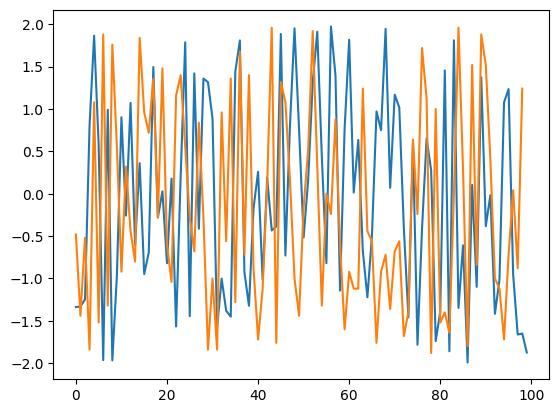

In [97]:
plt.plot(testing_set_Y)
plt.plot(training_set_Y)

In [98]:
metric = "wasserstein22"

#Testing to Training Distance Matrix
sample_size = len(training_set_D)

testing_dist_mat_PD = np.full((len(testing_set_D),sample_size),0, dtype=float)
for i in range(len(testing_set_D)):
    for j in range(sample_size):
        dist = distance_between(training_set_D[j], testing_set_D[i], metric)
        testing_dist_mat_PD[i][j] = dist

#Training-Training Distance Matrix
training_dist_mat_PD = np.full((sample_size,sample_size),0, dtype=float)
for i in range(sample_size):
    for j in range(i,sample_size):
        dist = distance_between(training_set_D[j], training_set_D[i], metric)
        training_dist_mat_PD[i][j], training_dist_mat_PD[j][i] = dist, dist

In [44]:
def find_closest(estimate):
    vals = {0,1,2,4,9}
    dist = dict()
    min = np.inf
    for val in vals:
        diff = abs(val - estimate)
        if diff < min:
            min = diff
        dist[diff] = val
    return dist[min]

4

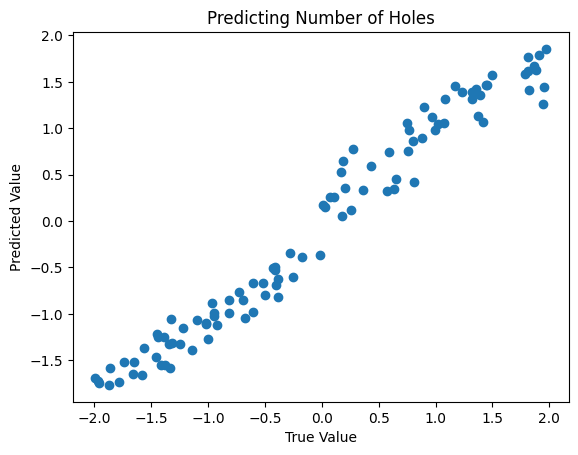

CV h: 0.012972972972972972
MSE: 0.048472076094755116


In [99]:
#Find CV value of h
hspace = np.linspace(0.01, 1, num=1000)
#hspace = [i+1 for i in range(30)]
h = find_CVh(training_dist_mat_PD, hspace, training_set_Y, estimator="nw")
#Produce estimates
estimates = []
mse = 0
#correct = 0
for i in range(len(testing_dist_mat_PD)):
    estimate = nw_estimator(testing_dist_mat_PD[i],training_set_Y, h)
    #estimate = find_closest(estimate)
    estimates.append(estimate)
    mse += (estimate - testing_set_Y[i])**2
    #if estimate == testing_set_Y[i]: correct += 1
plt.scatter(testing_set_Y, estimates)
plt.title("Predicting Number of Holes")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.show()
print("CV h: " + str(h))
print("MSE: " + str(mse/len(testing_set_Y)))
#print("Accuracy: " + str(correct/len(testing_set_Y)))

In [73]:
#PD into Persistence Image vector converter
min_b = 0
max_b = 2
min_d = 0
max_d = 2
min_l = 0
max_l = 2
image = gudhi.representations.vector_methods.PersistenceImage(resolution = [10, 10], im_range = [min_b, max_b, min_l, max_l])

#Computing Distance Matrix - Testing
testing_dist_mat_PI = np.full((len(testing_set_D),sample_size),0, dtype=float)
for i in range(len(testing_set_D)):
    for j in range(sample_size):
        pair = image.fit_transform([training_set_D[j].pd, testing_set_D[i].pd])
        dist = np.linalg.norm(pair[0]-pair[1])
        testing_dist_mat_PI[i][j] = dist

#Computing Distance Matrix - Training
training_dist_mat_PI = np.full((sample_size,sample_size),0, dtype=float)
for i in range(sample_size):
    for j in range(i,sample_size):
        pair = image.fit_transform([training_set_D[j].pd, training_set_D[i].pd])
        dist = np.linalg.norm(pair[0]-pair[1])
        training_dist_mat_PI[i][j], training_dist_mat_PI[j][i] = dist, dist

AttributeError: module 'gudhi' has no attribute 'representations'

/var/folders/tz/h_2j3rpx0xngnd4w1l6sjyk40000gn/T/ipykernel_81156/711515329.py:25: RuntimeWarning: invalid value encountered in scalar divide
  final = estimate/total_ker


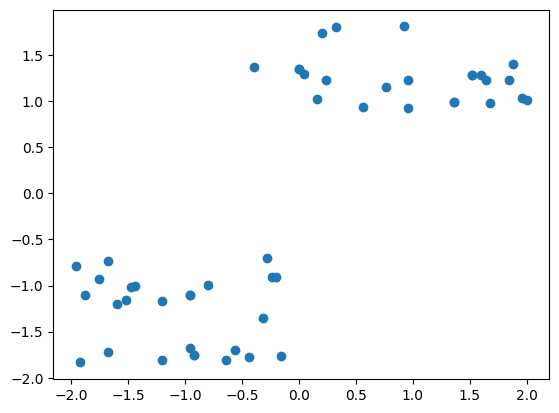

CV h: 1.0
MSE: 0.7051186904244149


In [443]:
#Compute CVh
hspace = np.linspace(0.01, 1, num=1000)
#hspace = [i+1 for i in range(50)]
h = find_CVh(training_dist_mat_PI, hspace, training_set_Y, estimator="nw")
#Produce estimates
estimates = []
mse = 0
for i in range(len(testing_dist_mat_PI)):
    estimate = nw_estimator(testing_dist_mat_PI[i],training_set_Y, h)
    estimates.append(estimate)
    mse += (estimate - testing_set_Y[i])**2
plt.scatter(testing_set_Y, estimates)
plt.show()
print("CV h: " + str(h))
print("MSE: " + str(mse/len(testing_set_Y)))

In [432]:
PIs = image.fit_transform([diag.pd for diag in training_set_D])
PIs_testing = image.fit_transform([diag.pd for diag in testing_set_D])

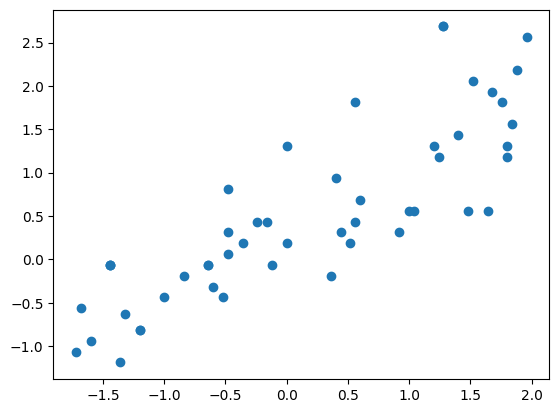

MSE: 0.5225267603490874


In [435]:
linreg = sklearn.linear_model.LinearRegression().fit(PIs, training_set_Y)
estimates = linreg.predict(PIs_testing)
mse = 0
for i in range(len(testing_dist_mat_PI)):
    estimate = estimates[i]
    mse += (estimate - testing_set_Y[i])**2
plt.scatter(testing_set_Y, estimates)
plt.show()
print("MSE: " + str(mse/len(testing_set_Y)))

In [62]:
training_dist_mat_Y = np.full((sample_size,sample_size),0, dtype=float)
for i in range(sample_size):
    for j in range(i,sample_size):
        dist = abs(training_set_Y[j] - training_set_Y[i])
        training_dist_mat_Y[i][j], training_dist_mat_Y[j][i] = dist, dist


PD_dcorr = dist_corr(training_dist_mat_PD,training_dist_mat_Y)
print("PD dcorr = " + str(PD_dcorr))
PI_dcorr = dist_corr(training_dist_mat_PI,training_dist_mat_Y)
print("PI dcorr = " + str(PI_dcorr))

PD dcorr = 0.25262414552329643


NameError: name 'training_dist_mat_PI' is not defined

In [ ]:
"""
import csv

filename = 'dist_mat.csv'

with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dist_mat)

with open('dist_mat.csv', mode='r') as file:
    reader = csv.reader(file)
    data = [row for row in reader]

# Convert the data to a NumPy ndarray
dist_mat = np.array(data, dtype=float)
"""

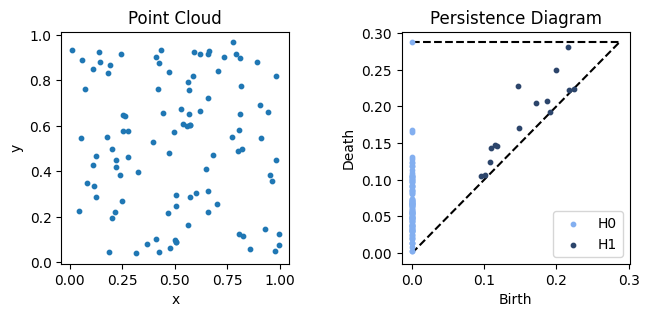

In [380]:
data = np.random.random((100,2))
test1 = PersisMod(data)
test1.showGs()

In [412]:
landscape = gudhi.representations.vector_methods.Landscape(num_landscapes=2,resolution=10)

In [413]:
l = landscape.fit_transform([test1.pd.drop('HomologyG', axis=1).to_numpy()])

/Users/sakshamaggarwal/Local_storage/tdaCodeBase/venv/lib/python3.8/site-packages/gudhi/representations/vector_methods.py:180: RuntimeWarning: invalid value encountered in cast
  min_idx = np.clip(np.ceil((px          - self.sample_range[0]) / step_x).astype(int), 0, self.new_resolution)
/Users/sakshamaggarwal/Local_storage/tdaCodeBase/venv/lib/python3.8/site-packages/gudhi/representations/vector_methods.py:181: RuntimeWarning: invalid value encountered in cast
  mid_idx = np.clip(np.ceil((0.5*(py+px) - self.sample_range[0]) / step_x).astype(int), 0, self.new_resolution)
/Users/sakshamaggarwal/Local_storage/tdaCodeBase/venv/lib/python3.8/site-packages/gudhi/representations/vector_methods.py:182: RuntimeWarning: invalid value encountered in cast
  max_idx = np.clip(np.ceil((py          - self.sample_range[0]) / step_x).astype(int), 0, self.new_resolution)


In [414]:
l[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])